In [1]:
import os
import torch
import numpy as np
from pprint import pprint
from dataclasses import dataclass, asdict
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

import torch.nn.functional as F

from conditional_rate_matching.models.generative_models.crm import CRM
from conditional_rate_matching.configs.configs_classes.config_crm import CRMConfig,BasicPipelineConfig
from conditional_rate_matching.data.states_dataloaders_config import StatesDataloaderConfig
from conditional_rate_matching.data.dataloaders_utils import get_dataloaders_crm
from conditional_rate_matching.models.trainers.call_all_trainers import call_trainer

from conditional_rate_matching.configs.config_files import ExperimentFiles

from conditional_rate_matching.configs.configs_classes.config_crm import CRMConfig
from conditional_rate_matching.configs.configs_classes.config_crm import CRMTrainerConfig

from conditional_rate_matching.models.trainers.crm_trainer import CRMTrainer

from conditional_rate_matching.models.trainers.crm_trainer import CRMDataloder
from conditional_rate_matching.models.pipelines.thermostat.crm_thermostat_config import ConstantThermostatConfig,LogThermostatConfig


from conditional_rate_matching.models.metrics.crm_loglikelihood import calculate_batch_log_likelihood,rate_to_probabilities
from conditional_rate_matching.models.metrics.crm_loglikelihood import get_log_likelihood
from torch.distributions import Categorical


In [2]:
from conditional_rate_matching.utils.plots.histogram_colors_plots import (
    plot_time_series_histograms,
    get_conditional_histograms_paths,
    categorical_counts_per_path,
    categorical_histogram_dataloader,
    plot_histograms_pairs
)

In [3]:
config = CRMConfig()
config_b = CRMConfig()

gamma = 1.
vocab_size = 6
dimensions = 2
num_grid_points = 100
dirichlet_alpha = 1.
number_of_steps = 20

t_grid = torch.linspace(0.,1.,num_grid_points)
config.data0 = StatesDataloaderConfig(dimensions=dimensions,vocab_size=vocab_size)
config.data1 = StatesDataloaderConfig(dirichlet_alpha=dirichlet_alpha,dimensions=dimensions,vocab_size=vocab_size,total_data_size=1000,test_size=0.1)
config.pipeline = BasicPipelineConfig(number_of_steps=number_of_steps)
config.thermostat = ConstantThermostatConfig(gamma=gamma)
config.trainer = CRMTrainerConfig(number_of_epochs=100,learning_rate=1e-3)

crm = CRM(config=config)

config_b.data0 = config.data1
config_b.data1 = config.data0
config_b.pipeline = config.pipeline
config_b.thermostat = config.thermostat

crm_b = CRM(config=config_b)

crm_b.dataloader_0 = crm.dataloader_1
crm_b.dataloader_1 = crm.dataloader_0

crm_b.pipeline.dataloder_0 = crm.dataloader_1
crm_b.pipeline.dataloder_1 = crm.dataloader_0

In [ ]:
databatch1 = next(crm.dataloader_1.train().__iter__())
x_1 = databatch1[0]
databatch0 = next(crm.dataloader_0.train().__iter__())
x_0 = databatch0[0]

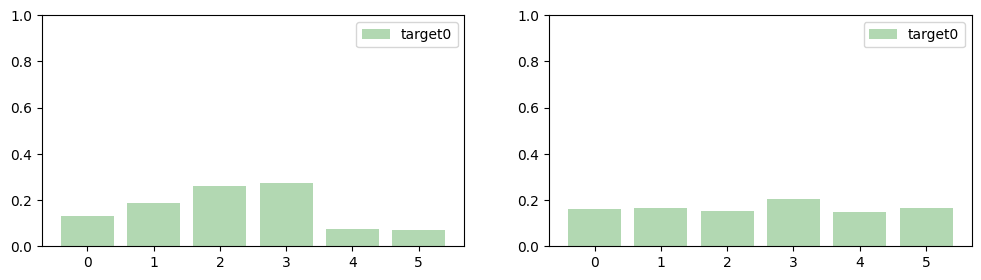

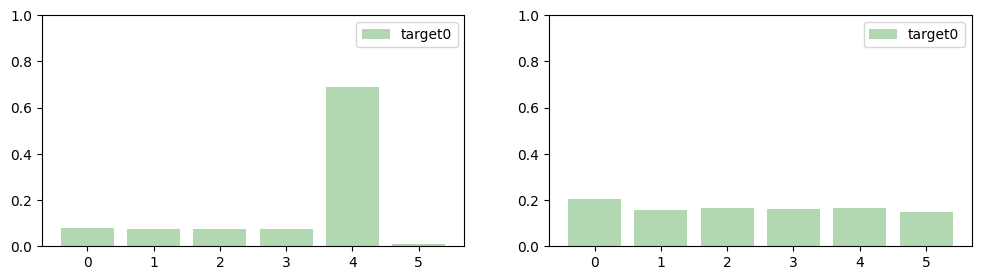

In [4]:
hist0_b = categorical_histogram_dataloader(crm_b.dataloader_0, dimensions, vocab_size, train=True,maximum_test_sample_size = 2000)
hist1_b = categorical_histogram_dataloader(crm_b.dataloader_1, dimensions, vocab_size, train=True,maximum_test_sample_size = 2000)

plot_histograms_pairs(hist0_b[0],hist1_b[0])
plot_histograms_pairs(hist0_b[1],hist1_b[1])

In [5]:
x_f, x_path, t_path = crm.pipeline(sample_size=500,return_path=True)
x_f, x_path_b, t_path_b = crm_b.pipeline(sample_size=500,return_path=True)

0it [00:00, ?it/s]

20it [00:00, 369.00it/s]
20it [00:00, 457.80it/s]
20it [00:00, 425.09it/s]
20it [00:00, 371.61it/s]
20it [00:00, 376.96it/s]
20it [00:00, 369.95it/s]
20it [00:00, 304.88it/s]
20it [00:00, 316.42it/s]


In [6]:
generative_histogram = categorical_counts_per_path(x_path,dimensions=dimensions,vocab_size=vocab_size,normalize=True)
generative_histogram_b = categorical_counts_per_path(x_path_b,dimensions=dimensions,vocab_size=vocab_size,normalize=True)
conditional_histograms_paths = get_conditional_histograms_paths(crm,t_grid)

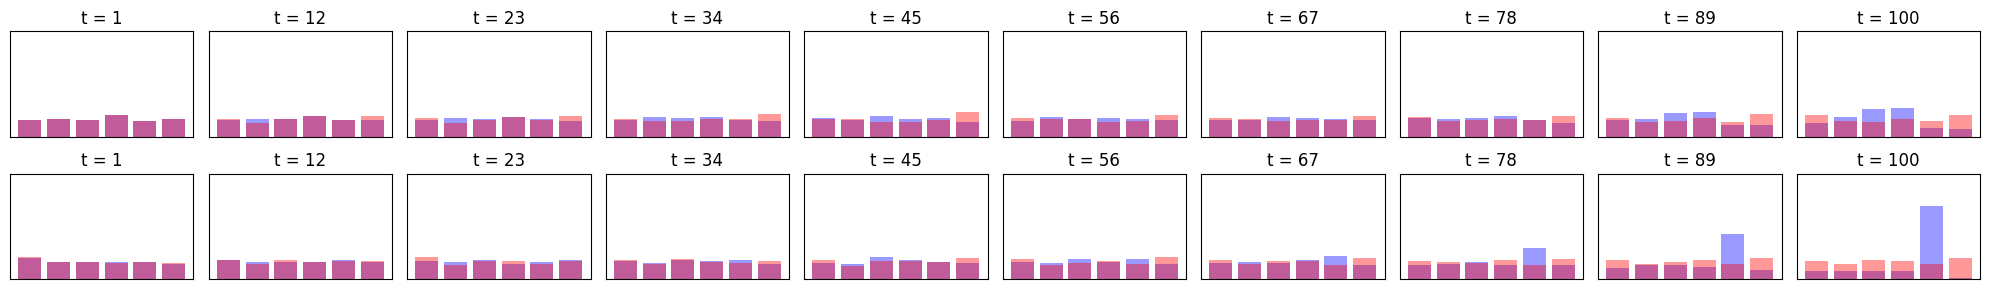

array([ 0, 11, 22, 33, 44, 55, 66, 77, 88, 99])

In [7]:
plot_time_series_histograms(conditional_histograms_paths,generative_histogram,num_timesteps_to_plot=10,figsize_tuple=(20, 3),plot_path=None)

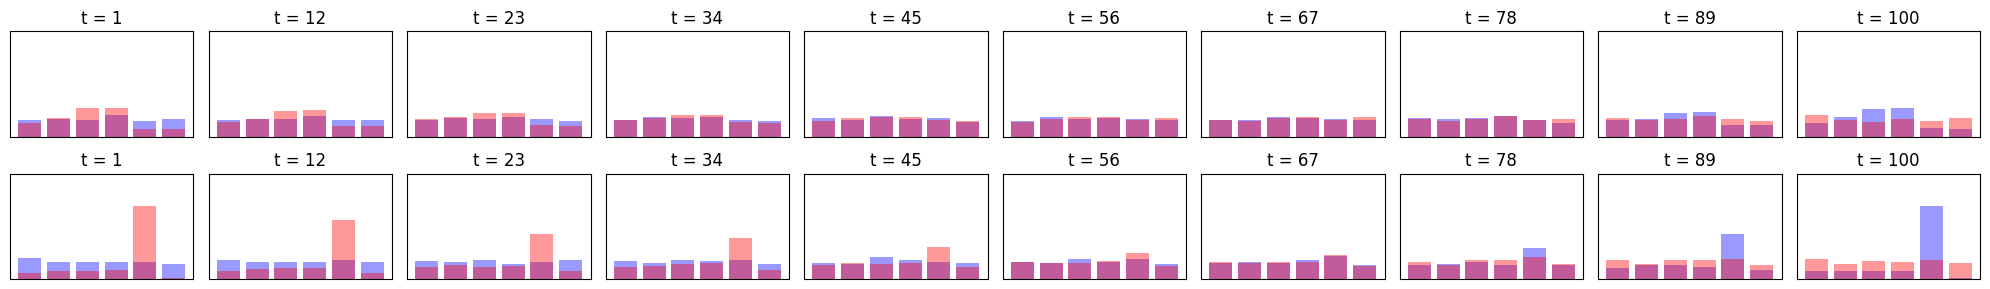

array([ 0, 11, 22, 33, 44, 55, 66, 77, 88, 99])

In [8]:
plot_time_series_histograms(conditional_histograms_paths,generative_histogram_b,num_timesteps_to_plot=10,figsize_tuple=(20, 3),plot_path=None)

# Likelihood

In [ ]:
#NMC = 100

ignore_ = 1
databatch1 = next(crm.dataloader_1.train().__iter__())
x_1 = databatch1[0]

databatch0 = next(crm.dataloader_0.train().__iter__())
x_0 = databatch0[0]

batch_size = x_1.shape[0]
#x_1 = torch.repeat_interleave(x_1,NMC,dim=0)

In [9]:
get_log_likelihood(crm,crm_b)

20it [00:00, 539.52it/s]
20it [00:00, 426.12it/s]
20it [00:00, 262.81it/s]
20it [00:00, 347.70it/s]
20it [00:00, 325.17it/s]
20it [00:00, 305.79it/s]
20it [00:00, 366.37it/s]
20it [00:00, 303.58it/s]
20it [00:00, 295.60it/s]


tensor(0.3557, grad_fn=<DivBackward0>)